<a href="https://colab.research.google.com/github/DemianDeveloper/Machine_Learning/blob/main/XRP_price_predictable_FGI%2BRSI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#прогноз движения XRP на основе индексов FGI(индекс страха и жадности) и RSI
#API индекса FGI берём от сюда: https://alternative.me/crypto/fear-and-greed-index/

In [16]:
import requests

In [17]:
N = 1300

In [29]:
# создаём функцию запроса
def parse_fgi(N):
  url = 'https://api.alternative.me/fng/?format=csv&date_format=us'
  parameters = {
      'limit': N,
      'format': 'json'
  }

  response = requests.get(url, params=parameters)
  data = response.json()['data']
  fgi_values = [float(i['value']) for i in data][::-1]

  return fgi_values

fgi_values = parse_fgi(N)

In [ ]:
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
!pip install Ta-Lib

In [26]:
from datetime import datetime, timedelta
import pandas as pd
import talib
import numpy as np
from talib import abstract
import yfinance as yf


In [35]:
def parse_dates(N):
  end_date = datetime.today()
  start_date = end_date - timedelta(days=N)
  dates = pd.date_range(start=start_date, end=end_date)
  us_dates = dates.strftime('%Y-%m-%d').tolist()

  return us_dates



In [36]:
def parse_prices(coin, N):
    period = parse_dates(N)
    end_time = period[-1]
    start_time = period[0]
    data = yf.download(coin+'-USD', start_time, end_time)
    data.rename(columns = {'Open': 'open',
                         'High': 'high',
                         'Close': 'close',
                         'Volume': 'volume'}, inplace =True)
    return data

# Получаем исторические данные о ценах для XRP
data_prices = parse_prices('XRP', N)
print(data_prices)


[*********************100%%**********************]  1 of 1 completed

                open      high       Low     close  Adj Close      volume
Date                                                                     
2020-09-08  0.242029  0.243872  0.232833  0.236753   0.236753  1618416970
2020-09-09  0.236723  0.243213  0.234273  0.239609   0.239609  1203137131
2020-09-10  0.239689  0.249185  0.239570  0.243530   0.243530  1353359148
2020-09-11  0.243530  0.244815  0.237520  0.243292   0.243292  1096662166
2020-09-12  0.243055  0.248752  0.241820  0.247814   0.247814  1043746083
...              ...       ...       ...       ...        ...         ...
2024-03-26  0.641034  0.652814  0.627026  0.632253   0.632253  1799059517
2024-03-27  0.632253  0.634468  0.608322  0.611964   0.611964  1989187555
2024-03-28  0.611949  0.636447  0.604837  0.624554   0.624554  1783253508
2024-03-29  0.624570  0.643995  0.610470  0.630750   0.630750  1874392966
2024-03-30  0.630753  0.636456  0.618905  0.621836   0.621836  1042947263

[1300 rows x 6 columns]


In [38]:
def indicators(df, N):
  df['rsi'] = abstract.RSI(df)
  df['sma'] = abstract.SMA(df)
  df['fgi'] = parse_fgi(N)
  return df

df = indicators(data_prices, N)
df

,open,high,Low,close,Adj Close,volume,rsi,sma,fgi
Date,,,,,,,,,
2020-09-08,0.242029,0.243872,0.232833,0.236753,0.236753,1618416970,NaN,NaN,38.0
2020-09-09,0.236723,0.243213,0.234273,0.239609,0.239609,1203137131,NaN,NaN,38.0
2020-09-10,0.239689,0.249185,0.239570,0.243530,0.243530,1353359148,NaN,NaN,41.0
2020-09-11,0.243530,0.244815,0.237520,0.243292,0.243292,1096662166,NaN,NaN,41.0
2020-09-12,0.243055,0.248752,0.241820,0.247814,0.247814,1043746083,NaN,NaN,38.0
...,...,...,...,...,...,...,...,...,...
2024-03-26,0.641034,0.652814,0.627026,0.632253,0.632253,1799059517,52.172001,0.625085,83.0
2024-03-27,0.632253,0.634468,0.608322,0.611964,0.611964,1989187555,48.708738,0.627104,80.0
2024-03-28,0.611949,0.636447,0.604837,0.624554,0.624554,1783253508,50.887402,0.628380,79.0


In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

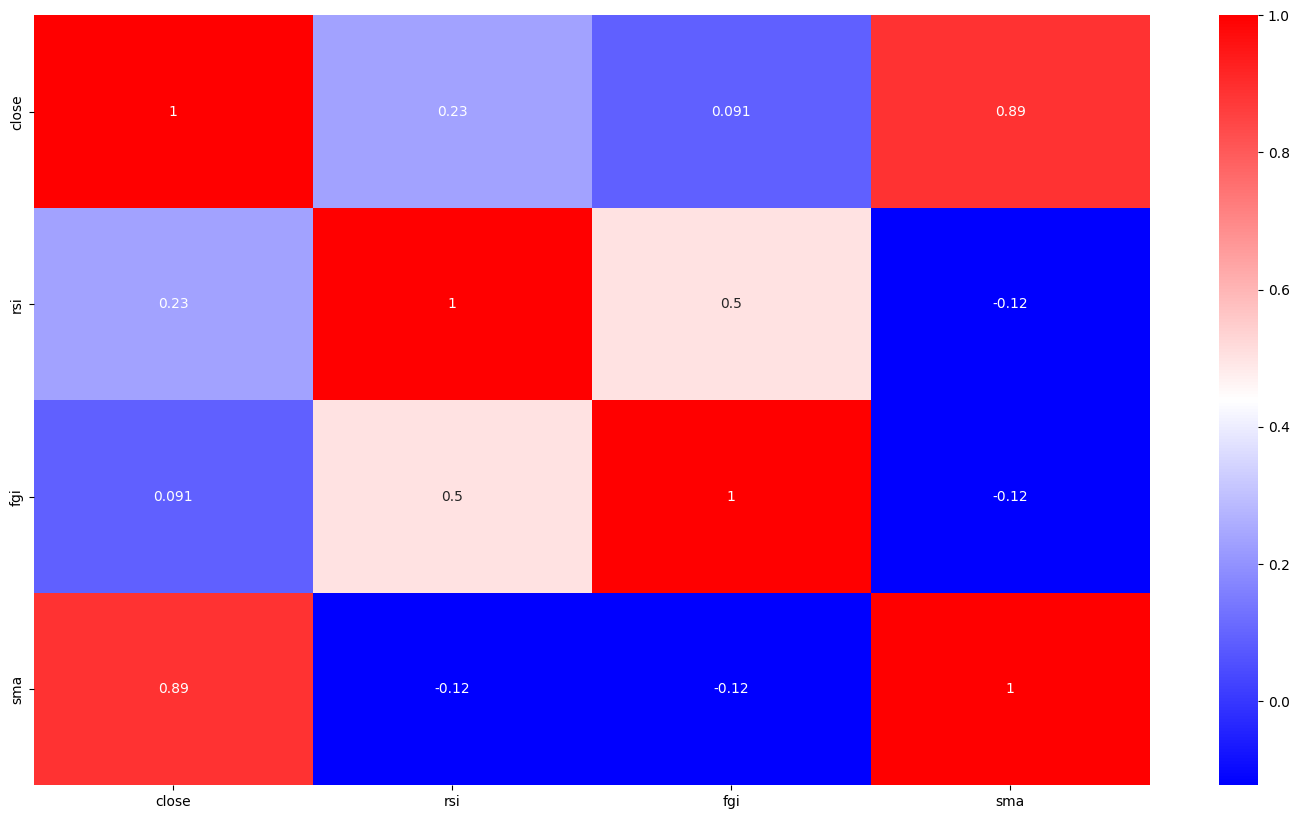

In [40]:
def corr_matrix(df):
  df = df[['close', 'rsi', 'fgi', 'sma']]
  corr_df = df.corr(method='pearson')
  plt.figure(figsize = (18, 10))
  sns.heatmap(corr_df, cmap = 'bwr', annot=True)
  plt.show()

corr_matrix(df)

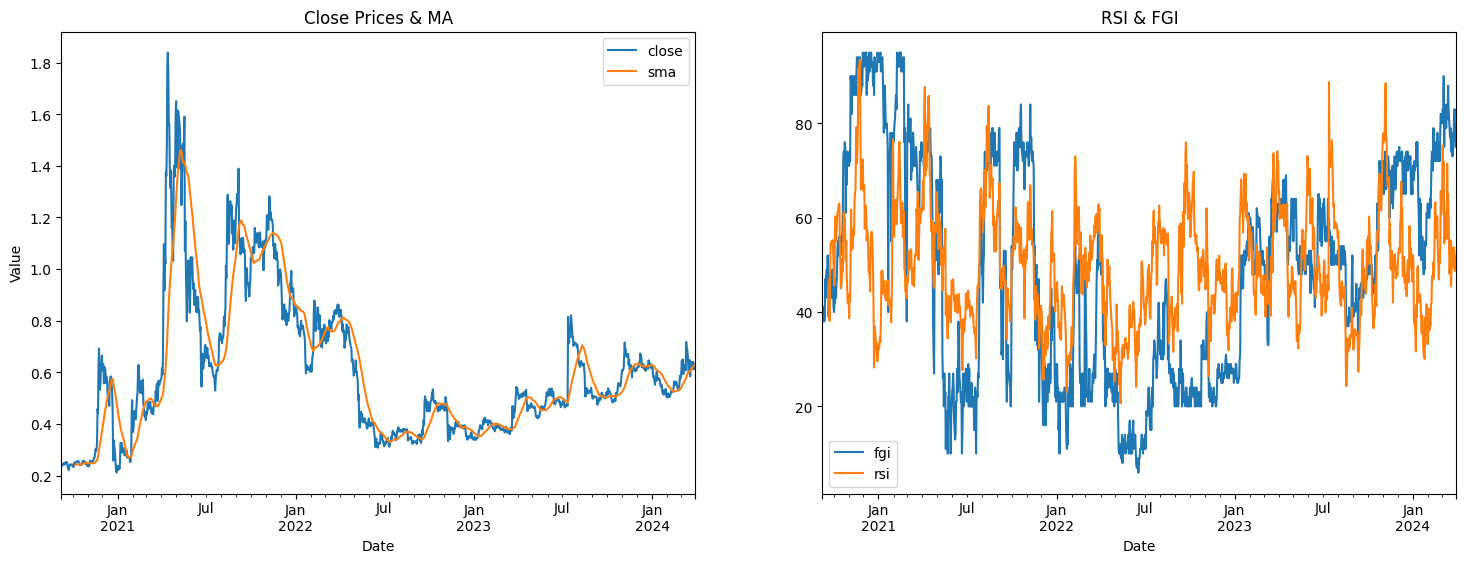

In [42]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
df[['close', 'sma']].plot(ax=axes[0], title='Close Prices & MA', xlabel='Date', ylabel='Value')
df[['fgi', 'rsi']].plot(ax=axes[1], title='RSI & FGI', xlabel='Date')
plt.show()

In [43]:
y = np.where(df['close'].shift(-1) > df['close'], 1, 0)
df['y'] = y
df['p'] = df['close']
df[['p', 'y']]

,p,y
Date,,
2020-09-08,0.236753,1
2020-09-09,0.239609,1
2020-09-10,0.243530,0
2020-09-11,0.243292,1
2020-09-12,0.247814,0
...,...,...
2024-03-26,0.632253,0
2024-03-27,0.611964,1
2024-03-28,0.624554,1


In [44]:
def preprocessing(df):
  df.dropna(inplace=True)
  x = df[['rsi', 'fgi', 'sma']]
  y = df[['y']]
  p = df[['p']]

  return x, y, p

x, y, p = preprocessing(df)
x, y

(                  rsi   fgi       sma
 Date                                 
 2020-10-07  57.396951  46.0  0.242107
 2020-10-08  59.444425  48.0  0.242597
 2020-10-09  60.860024  53.0  0.243060
 2020-10-10  61.428733  55.0  0.243418
 2020-10-11  62.478792  52.0  0.243833
 ...               ...   ...       ...
 2024-03-26  52.172001  83.0  0.625085
 2024-03-27  48.708738  80.0  0.627104
 2024-03-28  50.887402  79.0  0.628380
 2024-03-29  51.968695  75.0  0.630211
 2024-03-30  50.254464  75.0  0.631395
 
 [1271 rows x 3 columns],
             y
 Date         
 2020-10-07  1
 2020-10-08  1
 2020-10-09  1
 2020-10-10  1
 2020-10-11  1
 ...        ..
 2024-03-26  0
 2024-03-27  1
 2024-03-28  1
 2024-03-29  0
 2024-03-30  0
 
 [1271 rows x 1 columns])

In [45]:
percent_for_train = 0.7
split = int(percent_for_train * len(x))

X_train = x[:split]
Y_train = y[:split]
p_train = p[:split]

X_test = x[:split]
Y_test = y[:split]
p_test = p[:split]
[X_test, Y_test]

[                  rsi   fgi       sma
 Date                                 
 2020-10-07  57.396951  46.0  0.242107
 2020-10-08  59.444425  48.0  0.242597
 2020-10-09  60.860024  53.0  0.243060
 2020-10-10  61.428733  55.0  0.243418
 2020-10-11  62.478792  52.0  0.243833
 ...               ...   ...       ...
 2023-03-10  43.552891  33.0  0.382345
 2023-03-11  41.701656  33.0  0.381824
 2023-03-12  45.936783  49.0  0.381513
 2023-03-13  46.240267  56.0  0.381172
 2023-03-14  46.580437  50.0  0.381139
 
 [889 rows x 3 columns],
             y
 Date         
 2020-10-07  1
 2020-10-08  1
 2020-10-09  1
 2020-10-10  1
 2020-10-11  1
 ...        ..
 2023-03-10  0
 2023-03-11  1
 2023-03-12  1
 2023-03-13  1
 2023-03-14  0
 
 [889 rows x 1 columns]]

In [46]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [47]:
model = LogisticRegression()

In [52]:
def ML(clf, X_train, X_test, Y_train, Y_test):
  clf.fit(X_train, Y_train)
  preds = clf.predict(X_test)
  acc_score = accuracy_score(Y_test, preds)
  return preds, acc_score

preds, accuracy_score = ML(model, X_train, X_test, Y_train, Y_test)
accuracy_score

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.5230596175478065

In [56]:
signals =[]
for pred in preds:
  if pred == 0:
    signals.append(-1)
  else:
    signals.append(1)

position = 0
decisions = []
for signal in signals:
  if signal == -1:
    if position == -1:
      decisions.append(0)
    else:
      decisions.append(signal)
      position = signal

  else:
    if position == 1:
      decision = signal
    else:
      decisions.append(signal)
      position = signal

count = decisions.count(1)
count

32